# Natural Language Processing: Kaggle's Tweet Disaster competition

This project is part of a Kaggle's competition and aims to develop abilities in Natural Language Processing (NLP) problems. Here, the objecive is to predict the occurance of real disasters through the words found in tweets from several places. Available data includes a train set (more detailed information bellow), and a test set. The full submission and final score can be checked at my personal page in Kaggle (to be updated here).

This notebook is inspired in some previous work published in Kaggle.

*References:*

- FeatureExtraction+RandomForestClassifier: https://www.kaggle.com/code/abdulaziz04/featureextraction-randomforestclassifier
- EDA+Preprocessing+Emedding+Model: https://www.kaggle.com/code/rakeshku1993/eda-preprocessing-emedding-model

### Importing the data and querying the first infomations

- **id** - a unique identifier for each tweet
- **text** - the text of the tweet
- **location** - the location the tweet was sent from (may be blank)
- **keyword** - a particular keyword from the tweet (may be blank)
- **target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [196]:
#Basic package
import pandas as pd

# Math and plot packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

# Text analysis packages
import re
import string
from nltk.corpus import words
from nltk.corpus import stopwords
from collections import defaultdict
from spellchecker import SpellChecker

# Encoders, tokenizers
import gensim
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec as w2v
from category_encoders import BinaryEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

#Pre training packages
from sklearn.decomposition import PCA

In [95]:
train_data = pd.read_csv('train.csv')
test_data =  pd.read_csv('test.csv')

In [96]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [97]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Text(0.5, 1.0, 'Test set')

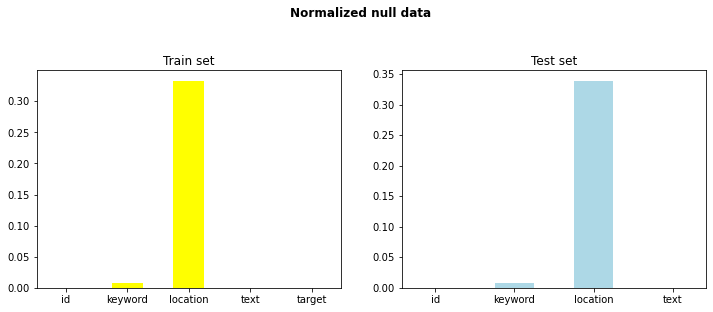

In [98]:
# Checking the amount of null information
trainNull = train_data.isnull().sum()
trainNull_percent = round(trainNull/train_data.shape[0], 3)

testNull = test_data.isnull().sum()
testNull_percent = round(testNull/test_data.shape[0], 3)

labels_train = trainNull.index
labels_test = testNull.index
width = 0.5

# Bar plot
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Normalized null data', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1.bar(labels_train, trainNull_percent, width, color='yellow')
ax1.set_title('Train set')
ax2.bar(labels_test, testNull_percent, width, color='lightblue')
ax2.set_title('Test set')

<AxesSubplot:>

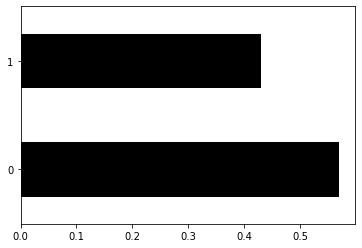

In [99]:
#Checking the balance between target classes
#(1 = real disaster, 0 = no disaster)

train_data['target'].value_counts(normalize=True).plot.barh(color='black')

Text(0.5, 1.0, 'Test set')

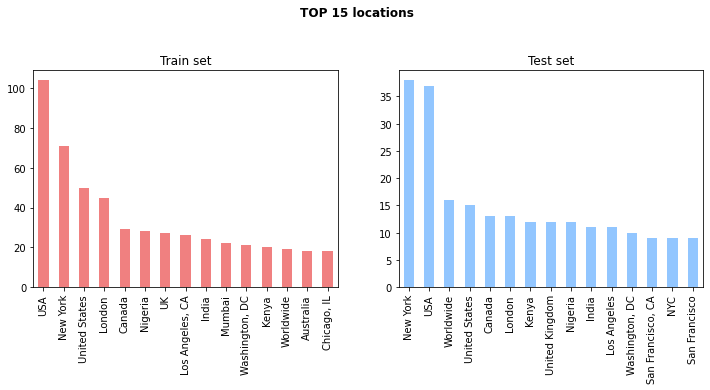

In [100]:
fig2,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig2.suptitle('TOP 15 locations', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1 = train_data['location'].value_counts()[:15].plot.bar(ax=ax1, color='lightcoral')
ax1.set_title('Train set')
ax2 = test_data['location'].value_counts()[:15].plot.bar(ax=ax2)
ax2.set_title('Test set')

In [101]:
train_data.location.value_counts()

USA                       104
New York                   71
United States              50
London                     45
Canada                     29
                         ... 
Depok                       1
Pig Symbol, Alabama         1
dundalk ireland             1
Arvada, CO                  1
In a crazy genius mind      1
Name: location, Length: 3341, dtype: int64

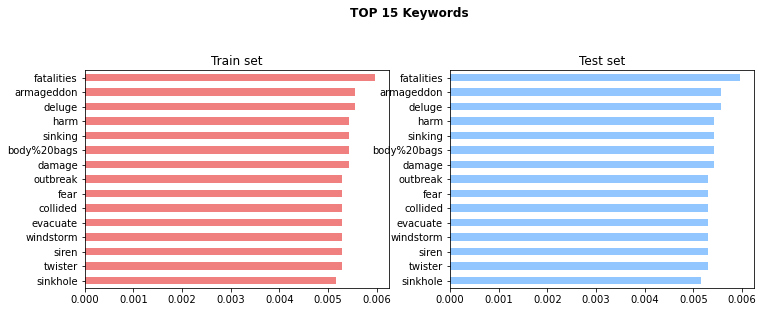

In [102]:
fig2,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig2.suptitle('TOP 15 Keywords', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')


ax1 = train_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 color='lightcoral',
                                                                                 fontsize=10,
                                                                                 title='Train set',
                                                                                 ax=ax1)

ax2 = train_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 fontsize=10,
                                                                                 title='Test set',
                                                                                 ax=ax2)

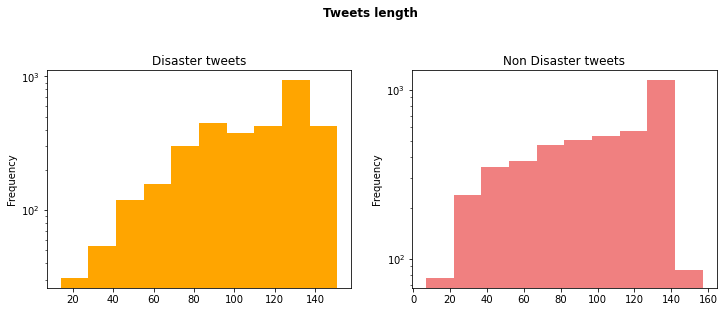

In [103]:
fig3,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig3.suptitle('Tweets length', y=1.1, weight='bold', size='large')

ax1 = train_data.query("target==1")["text"].str.len().plot(kind="hist",
                                                           color="orange",
                                                           title="Disaster tweets",
                                                           ax=ax1)
ax1.set_yscale('log')

ax2 = train_data.query("target==0")["text"].str.len().plot(kind="hist",
                                                           color="lightcoral",
                                                           title="Non Disaster tweets",
                                                           ax=ax2)
ax2.set_yscale('log')

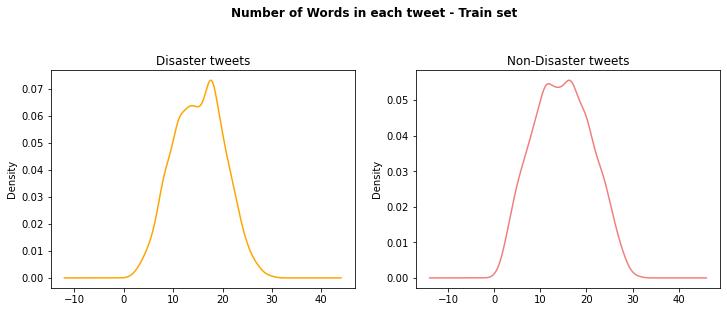

In [104]:
fig4,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig4.suptitle('Number of Words in each tweet - Train set', y=1.1, weight='bold', size='large')

ax1 = train_data.query("target==1").text.map(lambda x: len(x.split())).plot(kind="kde",
                                                                            color="orange",
                                                                            title="Disaster tweets",
                                                                            ax=ax1)

ax2 = train_data.query("target==0").text.map(lambda x: len(x.split())).plot(kind="kde",
                                                                            color="lightcoral",
                                                                            title="Non-Disaster tweets",
                                                                            ax=ax2)

/home/raissa/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/raissa/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


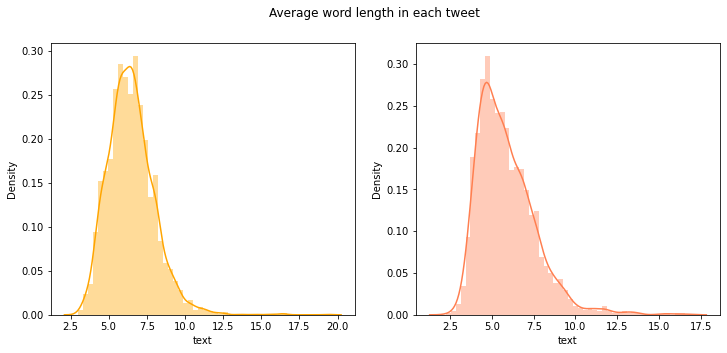

In [105]:
fig5, axes = plt.subplots(1, 2, figsize=(12,5))
fig5.suptitle('Average word length in each tweet')

each_words_len = train_data.query("target==1").text.str.split().map(lambda x: [len(i) for i in x])
sns.distplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=axes[0], color="orange");

each_words_len = train_data.query("target==0").text.str.split().map(lambda x: [len(i) for i in x])
sns.distplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=axes[1], color='coral');

In [106]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [107]:
def plot_punctuations(df, target):
    
    punctations_dict = defaultdict(int)
    
    for idx, text in df[df["target"]==target].text.iteritems():
        for token in text.split():
            if token in string.punctuation:
                punctations_dict[token] +=1   

    return dict(sorted(punctations_dict.items(), key=lambda x: x[1], reverse=True))


dt_punctuations = plot_punctuations(train_data, target=1)
ndt_punctuations = plot_punctuations(train_data, target=0)

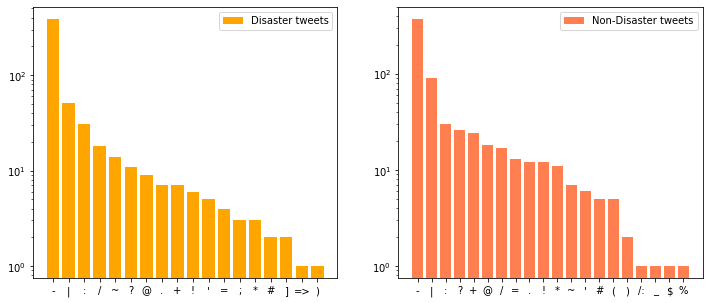

In [108]:
fig5, axes = plt.subplots(1, 2, figsize=(12,5))

x1, y1 = zip(*dt_punctuations.items())
axes[0].bar(x1, y1, color="orange", label="Disaster tweets")
axes[0].legend()
axes[0].set_yscale('log')


x2, y2 = zip(*ndt_punctuations.items())
axes[1].bar(x2, y2, color="coral", label="Non-Disaster tweets")
axes[1].legend()
axes[1].set_yscale('log')

In [109]:
stop_words= set(stopwords.words("english"))

# updating the stopwords considering the following list
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color= "black", 
               colormap="Paired",
               max_font_size=150)

In order to plot de the word cloud, we will use the method **plt.imshow**. According to matplotlib documentation: *Display data as an image, i.e., on a 2D regular raster. The input may either be actual RGB(A) data, or 2D scalar data, which will be rendered as a pseudocolor image.*


Word Cloud for Disaster Tweets


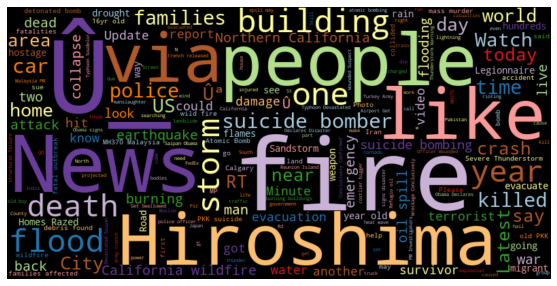


Word Cloud for Non-Disaster Tweets


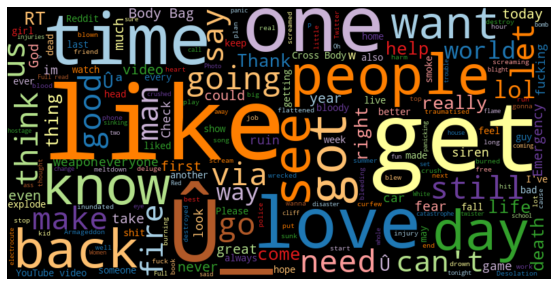

In [110]:
disaster_tweets = (train_data.query("target==1").text).str.cat(sep=" ")  # str.cat -- string concatenation

non_disaster_tweets = (train_data.query("target==0").text).str.cat(sep=" ")

print('\033[1m'"\nWord Cloud for Disaster Tweets"'\033[0m')
wc.generate(disaster_tweets)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('\033[1m'"\nWord Cloud for Non-Disaster Tweets"'\033[0m')
wc.generate(non_disaster_tweets)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Feature Engineering

**TASK 1:** tweet length (in number of chars)

In [111]:
train_data['num chars'] = train_data["text"].str.len().values
test_data['num chars']  = test_data["text"].str.len().values

In [112]:
train_data.head(2)

,id,keyword,location,text,target,num chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38


In [113]:
test_data.head(2)

,id,keyword,location,text,num chars
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64


**TASK 2:** number of special chars

In [114]:
def count_special_chars(df):
    
    '''
    Uses regex to identify special chars in text. 
    [^a-zA-Z0-9\s] means: anything in the interval [] that is NOT (^): [a-z] or [A-Z] or [0-9] or \s (space)
    
    Parameters:
        df: Dataset
    Returns: 
        A list with the amount of special chars for each example of the dataset
    
    '''
    special_chars=[]
    
    for text in df['text']:
        special_chars.append(len(re.findall(r'[^a-zA-Z0-9\s]', text)))
    
    return special_chars

In [115]:
train_data['num special chars'] = count_special_chars(train_data)
test_data['num special chars']  =  count_special_chars(test_data)

In [116]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3


In [117]:
test_data.head(3)

,id,keyword,location,text,num chars,num special chars
0,0,NaN,NaN,Just happened a terrible car crash,34,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,3
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,2


**TASK 3:** standardize location representations

In [118]:
def split_location_countries(df):
    
    countries=[]
    location=[]
    
    for item in df['location'].astype(str).values:
        countries.append(item.split(',')[-1])
        location.append(item.split(',')[0])
        
    df['country']  = countries
    df['location'] = location
    
    assert len(countries)==df.shape[0]
    assert len(countries)==df.shape[0]
        
    return df

In [119]:
train_data = split_location_countries(train_data)
test_data  = split_location_countries(test_data)

In [120]:
def remove_special_chars(text):
    
    '''
    The function removes any char that is not a word character (uppercase or lowercase) and replaces it for
    a simple blank space.
    The regular expression [^a-zA-Z] matches any char that is NOT(^) a word (like special chars, space or
    numbers).
    '''
    
    return re.sub(r"[^a-zA-Z]", " ", text)

In [121]:
train_data['location'] = train_data.location.apply(lambda x: remove_special_chars(x))
test_data['location']  = test_data.location.apply(lambda x: remove_special_chars(x))
train_data['country'] = train_data.location.apply(lambda x: remove_special_chars(x))
test_data['country']  = test_data.location.apply(lambda x: remove_special_chars(x))

In [122]:
train_data.country.value_counts()

nan                         2533
USA                          108
New York                      95
London                        70
United States                 50
                            ... 
Paonia                         1
Caribbean                      1
South africa                   1
Saipan                         1
London Bristol Guildford       1
Name: country, Length: 2863, dtype: int64

In [123]:
train_data.location.value_counts()

nan                         2533
USA                          108
New York                      95
London                        70
United States                 50
                            ... 
Paonia                         1
Caribbean                      1
South africa                   1
Saipan                         1
London Bristol Guildford       1
Name: location, Length: 2863, dtype: int64

Importing a table with most important cities in the world to standardize the countries notation

In [124]:
cities = pd.read_csv('worldcities.csv')
cities['city_ascii'] = cities['city_ascii'].str.lower()
cities.head(3)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000.0,1392685764
1,Jakarta,jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000.0,1360771077
2,Delhi,delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000.0,1356872604


In [125]:
columns = ['location', 'country']
for column in columns:
    train_data[column] = train_data[column].str.lower()
    test_data[column]  = test_data[column].str.lower()

In [126]:
def discover_country_from_city(df, column, cities_df):
    
    '''
    Splits the location field and searches for the name of cities to find their respective country
    '''
     
    index=0
    for item in df[column]:
        
        for new_item in item.split():
            if (new_item != 'nan') and (new_item in cities_df['city_ascii'].values):
                df.loc[index, 'country'] = cities_df[cities_df['city_ascii']==new_item].iso2.values[0]
        else:
            pass
        
        index+=1
    
    return df

In [127]:
for colum in columns:
    train_data = discover_country_from_city(train_data, column, cities)
    test_data  = discover_country_from_city(test_data, column, cities)

In [128]:
train_data.country.value_counts()

nan                           2533
US                            1349
GB                             287
JP                             152
CA                             134
                              ... 
justin   ari follow    tvd       1
fimak a s ist bolge muduru       1
zac newsome loves me             1
no id                            1
m       pp                       1
Name: country, Length: 1567, dtype: int64

In [129]:
train_data[500:504]

,id,keyword,location,text,target,num chars,num special chars,country
500,725,attacked,lealman,Christian Attacked by Muslims at the Temple Mo...,1,122,9,US
501,726,attacked,los angeles,@envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...,0,136,7,los angeles
502,727,attacked,san francisco,Kelly Osbourne attacked for racist Donald Trum...,1,103,5,ML
503,728,attacked,gdjb asot,@eunice_njoki aiii she needs to chill and answ...,0,89,3,gdjb asot


Cities with double names are affected when we split the location field. To solve it, let's search for the full name of the cities

In [130]:
def discover_country_from_city_v2(df, column, cities_df):
    
    '''
    Uses the location field **with no splitting** and searches for the name of cities to find their 
    respective country
    '''
     
    index=0
    
    for item in df[column]:
        
        if (item != 'nan') and (item in cities_df['city_ascii'].values):
                df.loc[index, 'country'] = cities_df[cities_df['city_ascii']==item].iso2.values[0]
        else:
            pass
        
        index+=1
    
    return df

In [131]:
for column in columns:
    train_data = discover_country_from_city_v2(train_data, column, cities)
    test_data  = discover_country_from_city_v2(test_data, column, cities)

In [132]:
train_data.country.value_counts()

nan                      2533
US                       1540
GB                        290
JP                        152
CA                        135
                         ... 
zac newsome loves me        1
no id                       1
adventuring in narnia       1
     w patrick st           1
m       pp                  1
Name: country, Length: 1503, dtype: int64

In [133]:
train_data[500:504]

,id,keyword,location,text,target,num chars,num special chars,country
500,725,attacked,lealman,Christian Attacked by Muslims at the Temple Mo...,1,122,9,US
501,726,attacked,los angeles,@envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...,0,136,7,US
502,727,attacked,san francisco,Kelly Osbourne attacked for racist Donald Trum...,1,103,5,US
503,728,attacked,gdjb asot,@eunice_njoki aiii she needs to chill and answ...,0,89,3,gdjb asot


As we have a huge presence of US locations, let us import a USA database with states and main cities

In [134]:
usa_data = pd.read_csv('USAData.csv')

In [135]:
usa_columns = ['name', 'usps', 'State']
for column in usa_columns:
    usa_data[column] = usa_data[column].str.lower()

usa_data.head()

,rank,name,usps,pop2022,pop2010,growth,density,aland_sqmi,State
0,1,new york city,ny,8930002,8175133,0.0923,29729,300.381,new york
1,2,los angeles,ca,3919973,3792621,0.0336,8359,468.956,california
2,3,chicago,il,2756546,2695598,0.0226,12124,227.369,illinois
3,4,houston,tx,2345606,2099451,0.1172,3664,640.194,texas
4,5,phoenix,az,1640641,1445632,0.1349,3169,517.673,arizona


In [136]:
def find_USA_locations(df, column, cities_df):
    
    '''
    Finds USA locations and replace them by 'US' name in country field
    '''
    
    index=0
    usa_columns = ['State', 'usps', 'name']
    
    for item in df[column]:
        
        if item in ['new york', 'united states']:
            df.loc[index, 'country'] = 'US'
        
        else:
            for usa_column in usa_columns:
                if item in cities_df[usa_column].values:
                    df.loc[index, 'country'] = 'US'
                    df.loc[index, 'location']= item
                
                else:
                    pass
        
        index+=1
    
    return df

In [137]:
for column in columns:
    train_data = find_USA_locations(train_data, column, usa_data)
    test_data  = find_USA_locations(test_data, column, usa_data)

In [138]:
train_data.country.value_counts()

nan                           2533
US                            1833
GB                             281
JP                             152
CA                             122
                              ... 
the main                         1
justin   ari follow    tvd       1
zac newsome loves me             1
no id                            1
m       pp                       1
Name: country, Length: 1456, dtype: int64

In [139]:
def find_USA_locations_v2(df, column, cities_df):
    
    '''
    Splits the entries to find US locations
    '''
     
    index=0
    usa_columns = ['State', 'usps', 'name']
    for item in df[column]:
        
        for new_item in item.split():
            for usa_column in usa_columns:
                if new_item in cities_df[usa_column].values:
                    df.loc[index, 'country'] = 'US'
        else:
            pass
        
        index+=1
    
    return df

In [140]:
for column in columns:
    train_data = find_USA_locations_v2(train_data, column, usa_data)
    test_data  = find_USA_locations_v2(test_data, column, usa_data)

In [141]:
train_data.country.value_counts()

nan                         2533
US                          2048
GB                           272
JP                           138
CA                           112
                            ... 
taken by piper curda           1
ideally under a big tree       1
 rp                            1
dagenham                       1
m       pp                     1
Name: country, Length: 1341, dtype: int64

In [142]:
train_data.location.value_counts()

nan              2533
usa               108
new york          100
london             74
united states      50
                 ... 
 soooota            1
st austell          1
fairfield           1
irving              1
m       pp          1
Name: location, Length: 2741, dtype: int64

As our Cities database does not comprise all countries in the world, let us import a last, but complete country dataset and search for remaining entries...

In [143]:
countries = pd.read_csv('All countries.csv')

In [144]:
countries['country'] = countries['country'].str.lower()
countries['abbreviation'] = countries['abbreviation'].str.lower()

In [145]:
countries.head()

,abbreviation,country
0,af,afghanistan
1,ax,aland islands
2,al,albania
3,dz,algeria
4,as,american samoa


In [146]:
def search_remaining_countries(df, column, countries_df):
    '''
    Splits the entries to find US locations
    '''
     
    index=0
    for item in df[column]:
        
        if item in countries_df['country'].values:
            df.loc[index, 'country'] = countries_df[countries_df['country']==item].abbreviation.values[0]
        
        else:
            pass
        
        index+=1
    
    return df

In [147]:
train_data = search_remaining_countries(train_data, 'country', countries)
test_data  = search_remaining_countries(test_data, 'country', countries)

In [148]:
train_data.country.value_counts()

nan                  2533
US                   2048
GB                    272
JP                    138
CA                    112
                     ... 
     w patrick st       1
timeline kamu           1
poconos                 1
LK                      1
m       pp              1
Name: country, Length: 1340, dtype: int64

As we achieved less variation in ['country'] data than in the original ['location'] field, let us work with ['country'] feature from now on. 

To standardize it, the entries with **len(country)>3** and those which does not match any real country abbreviation will be tagged as NaN, as their location is mostly fake and brings no relevant information

In [149]:
def replace_with_nan_v1(df):
    
    '''This version 1 (v1) replaces entries with len()>3 for 'nan' values'''
    
    
    df['country']= np.where(df.country.str.len()>3, 'nan', df['country'])
    
    return df

In [150]:
train_data = replace_with_nan_v1(train_data)
test_data  = replace_with_nan_v1(test_data)

In [151]:
def replace_with_nan_v2(df, countries_df):
    
    '''This version 2 (v2) searches for countries abbreviations in the dataframe ['country'] entries. If an 
    entry does not match an existing country abbreviation, it is replaced by a 'nan' value'''
         
    index=0
    for item in df['country']:
        
        if (item != 'nan') and (item in countries_df['abbreviation'].values):
            pass
        
        else:
            df.loc[index, 'country'] = 'nan'
        
        index+=1
    
    return df

In [152]:
train_data = replace_with_nan_v2(train_data, countries)
test_data  = replace_with_nan_v2(test_data, countries)

In [153]:
train_data.country.value_counts().shape

(64,)

In [154]:
test_data.country.value_counts().shape

(32,)

In [155]:
train_data['country'] = train_data['country'].str.upper()
test_data['country']  = test_data['country'].str.upper()

**TASK 4:** Encode country and keywords

To encode **['country']**, we choose **Frequency Encoding**. As briefly explained in this post (https://towardsdatascience.com/how-to-encode-categorical-data-d44dde313131), this gives the probability of each class. Given the huge amount of possible locations, and the different frequencies distributions, we avoid a large matrix in conventional encoding plus inform the 'weight' of each place.

In [157]:
# Group it by type, find the size of each type, and divide by total event

# Train data
country_train_freq = train_data.groupby("country").size()/len(train_data)
train_data['country freq'] = train_data['country'].map(country_train_freq) 


# Test data
country_test_freq = test_data.groupby("country").size()/len(test_data)
test_data['country freq'] = test_data['country'].map(country_test_freq) 

To encode **['keywords']**, we choose conventional **Binary Encoding**.

In [158]:
def binary_encoder(df, column):
    
    be = BinaryEncoder(cols=[column])
    newdata = be.fit_transform(df[column])
    
    assert newdata.shape[0]==df.shape[0]
    
    df = pd.concat([df, newdata], axis=1)
    
    return df

In [159]:
train_data = binary_encoder(train_data, 'keyword')
test_data  = binary_encoder(test_data, 'keyword')

In [160]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,country,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7
0,1,NaN,nan,Our Deeds are the Reason of this #earthquake M...,1,69,1,NAN,0.959149,0,0,0,0,0,0,0,1
1,4,NaN,nan,Forest fire near La Ronge Sask. Canada,1,38,1,NAN,0.959149,0,0,0,0,0,0,0,1
2,5,NaN,nan,All residents asked to 'shelter in place' are ...,1,133,3,NAN,0.959149,0,0,0,0,0,0,0,1


**TASK 5:** Text cleaning and tokenizing

In [161]:
train_data['text']  = train_data['text'].apply(lambda x : remove_special_chars(x))
test_data['text']   = test_data['text'].apply(lambda x : remove_special_chars(x))

In [162]:
train_data.text

0       Our Deeds are the Reason of this  earthquake M...
1                  Forest fire near La Ronge Sask  Canada
2       All residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       Just got sent this photo from Ruby  Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609     aria ahrary  TheTawniest The out of control w...
7610    M            UTC   km S of Volcano Hawaii  htt...
7611    Police investigating after an e bike collided ...
7612    The Latest  More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [163]:
def tokenize_and_remove_stopwords(text):
    
    '''Removes stop words and non-English vocabulary'''
    
    # setting stop words
    stop_words = set(stopwords.words("english"))
    stop_words.update(['https', 'http', 'amp', 'co', 't', 'u', 'e', 'm', 'r' 'new', "i'm", 'im', "would",
                       'the'])
    
    # setting English vocabulary
    english_vocab = set(w.lower() for w in words.words())
    
    text = word_tokenize(text)
    clean_text = [word for word in text if word not in stop_words and word in english_vocab]
    
    return clean_text

In [165]:
train_data['text']  = train_data['text'].apply(lambda x : tokenize_and_remove_stopwords(x))
test_data['text']   = test_data['text'].apply(lambda x : tokenize_and_remove_stopwords(x))

In [166]:
#Word2Vec copy
train_copy = train_data.copy()
test_copy  = test_data.copy()

In [72]:
train_data.text

0                                        [earthquake, us]
1                                            [fire, near]
2       [shelter, place, notified, evacuation, shelter...
3                           [people, receive, evacuation]
4                       [got, sent, photo, smoke, school]
                              ...                        
7608           [giant, holding, bridge, collapse, nearby]
7609    [aria, control, wild, even, part, state, troub...
7610                                                   []
7611    [investigating, bike, car, bike, rider, seriou...
7612                                                   []
Name: text, Length: 7613, dtype: object

In [73]:
def lemmatizer(tokens):
    
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    
    for token in tokens:
        clean_tokens.append(lemmatizer.lemmatize(token).lower().strip())
     
    return " ".join(clean_tokens)

In [74]:
train_data['text']  = train_data['text'].apply(lambda x : lemmatizer(x))
test_data['text']   = test_data['text'].apply(lambda x : lemmatizer(x))

In [75]:
spell = SpellChecker()

def correct_spellings(text):
    
    '''Corrects mispelling words'''
    
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
            
    return " ".join(corrected_text)

In [76]:
train_data['text']  = train_data['text'].apply(lambda x : correct_spellings(x))
test_data['text']   = test_data['text'].apply(lambda x : correct_spellings(x))

In [77]:
train_data.text

0                                            earthquake u
1                                               fire near
2         shelter place notified evacuation shelter place
3                               people receive evacuation
4                             got sent photo smoke school
                              ...                        
7608                 giant holding bridge collapse nearby
7609          aria control wild even part state troubling
7610                                                     
7611    investigating bike car bike rider serious non ...
7612                                                     
Name: text, Length: 7613, dtype: object

For tokenization, we use the method **TfidfVectorizer**, which is a method from *feature_extraction* for texts available in Scikit Learn. According to the documentation:

- Convert a collection of raw documents to a matrix of TF-IDF features. Equivalent to *CountVectorizer* followed by *TfidfTransformer*.

The last one, according to Scikit Learn documentation:

- Transform a count matrix to a normalized tf or tf-idf representation.
- **Tf** means *term-frequency* while **tf-idf** means *term-frequency times inverse document-frequency*. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

In [78]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)

In [79]:
# For Train Set

train_texts = vectorizer.fit_transform(train_data['text'])
test_texts  = vectorizer.transform(test_data['text'])

In [80]:
train_texts.shape

(7613, 5229)

In [81]:
train_texts = pd.DataFrame(train_texts.toarray(), columns=vectorizer.get_feature_names_out())
test_texts  = pd.DataFrame(test_texts.toarray(), columns=vectorizer.get_feature_names_out())

In [82]:
train_texts.columns

Index(['a', 'aba', 'abandon', 'abandoned', 'abe', 'ability', 'abject',
       'ablaze', 'able', 'aboard',
       ...
       'youth', 'yr', 'yuan', 'zero', 'zionism', 'zionist', 'zo', 'zombie',
       'zone', 'zoom'],
      dtype='object', length=5229)

In [83]:
test_texts.columns

Index(['a', 'aba', 'abandon', 'abandoned', 'abe', 'ability', 'abject',
       'ablaze', 'able', 'aboard',
       ...
       'youth', 'yr', 'yuan', 'zero', 'zionism', 'zionist', 'zo', 'zombie',
       'zone', 'zoom'],
      dtype='object', length=5229)

### Training the model (1st try)

In [84]:
# Metrics
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# Methods
from sklearn.ensemble import RandomForestClassifier

In [85]:
train_data.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'num chars',
       'num special chars', 'country', 'country freq', 'keyword_0',
       'keyword_1', 'keyword_2', 'keyword_3', 'keyword_4', 'keyword_5',
       'keyword_6', 'keyword_7'],
      dtype='object')

In [86]:
xtrain = train_data.drop(columns=['id', 'keyword', 'location', 'text', 'country', 'target'])
xtrain = pd.concat([xtrain, train_texts], axis=1)

In [87]:
ytrain = train_data['target']

In [88]:
xtest = test_data.drop(columns=['id', 'keyword', 'location', 'text', 'country'])
xtest = pd.concat([xtest, test_texts], axis=1)

**Method 1:** splitting the train set into a validation subset

In [89]:
from sklearn.model_selection import train_test_split

As we don't have 'ytest', we are going to split 15% for validation set

In [90]:
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.15, random_state=42)

In [91]:
print('X train size:', xtrain.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid.shape)
print('Y validation size:', yvalid.shape)
print('X test size:', xtest.shape)

X train size: (6471, 5240)
Y train size: (6471,)
X validation size: (1142, 5240)
Y validation size: (1142,)
X test size: (3263, 5240)


In [92]:
RF = RandomForestClassifier() # using Gini Impurity algorithm (default)
    
# Set the steps of the pipeline
pipe = Pipeline(steps=[("RF", RF)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"RF__n_estimators": [100, 150, 200],
              "RF__max_depth":[7, 10, 15],
             } 

scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                       cv=5                    #CV 3-fold
                     )

search.fit(xtrain, ytrain)
results = search.cv_results_
method = search.best_estimator_

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print("Best parameters: ", search.best_params_)
print("Best index: ", search.best_index_)
print("Best estimator: ", search.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameter (CV score=0.764):
Best parameters:  {'RF__max_depth': 15, 'RF__n_estimators': 200}
Best index:  8
Best estimator:  Pipeline(steps=[('RF', RandomForestClassifier(max_depth=15, n_estimators=200))])


In [93]:
ypred_RF = method.predict_proba(xvalid)
pd.DataFrame(ypred_RF)

,0,1
0,0.661868,0.338132
1,0.578524,0.421476
2,0.532441,0.467559
3,0.634374,0.365626
4,0.593893,0.406107
...,...,...
1137,0.562609,0.437391
1138,0.598959,0.401041
1139,0.512058,0.487942
1140,0.568228,0.431772


In [95]:
results_df = pd.DataFrame(results)
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_RF__max_depth', 'param_RF__n_estimators', 'params',
       'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc',
       'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc',
       'std_test_roc_auc', 'rank_test_roc_auc', 'split0_train_roc_auc',
       'split1_train_roc_auc', 'split2_train_roc_auc', 'split3_train_roc_auc',
       'split4_train_roc_auc', 'mean_train_roc_auc', 'std_train_roc_auc',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'split4_train_accuracy', 'mean_train_accuracy',
       'std_train_accuracy'],
      dtype='object')

In [99]:
roc_results = results_df[[x for x in results_df.columns if 'roc_auc' in x]].T
roc_results

,0,1,2,3,4,5,6,7,8
split0_test_roc_auc,0.762272,0.762069,0.772482,0.755270,0.770899,0.769823,0.772933,0.767524,0.776012
split1_test_roc_auc,0.748100,0.753830,0.755878,0.748909,0.745634,0.758118,0.756904,0.758654,0.758972
split2_test_roc_auc,0.753362,0.769856,0.769487,0.761404,0.773671,0.779331,0.781945,0.773442,0.780772
split3_test_roc_auc,0.738863,0.728527,0.733735,0.733200,0.738651,0.742489,0.736991,0.747029,0.742407
split4_test_roc_auc,0.751678,0.755481,0.752881,0.748881,0.756049,0.758459,0.763098,0.762836,0.761164
mean_test_roc_auc,0.750855,0.753953,0.756893,0.749533,0.756981,0.761644,0.762374,0.761897,0.763866
std_test_roc_auc,0.007599,0.013911,0.013821,0.009396,0.013696,0.012404,0.015292,0.008915,0.013602
rank_test_roc_auc,8.000000,7.000000,6.000000,9.000000,5.000000,4.000000,2.000000,3.000000,1.000000
split0_train_roc_auc,0.811247,0.813282,0.817379,0.816554,0.836077,0.822776,0.853251,0.860539,0.852733
split1_train_roc_auc,0.814010,0.820731,0.814627,0.828249,0.831676,0.834234,0.857107,0.861375,0.858658


In [101]:
best = results_df[results_df['rank_test_roc_auc']==1]
best.T

,8
mean_fit_time,2.69546
std_fit_time,0.0368834
mean_score_time,0.165608
std_score_time,0.0065122
param_RF__max_depth,15
param_RF__n_estimators,200
params,"{'RF__max_depth': 15, 'RF__n_estimators': 200}"
split0_test_roc_auc,0.776012
split1_test_roc_auc,0.758972
split2_test_roc_auc,0.780772


## Word2Vec

Alternatively, let's train our model using a pre-trained model to better encode the vocabulary

In [174]:
# Create Skip Gram model
model2 = gensim.models.Word2Vec(train_copy['text'], min_count = 1, vector_size = 100, window = 5, sg = 1)

In [175]:
# Print results
print("Cosine similarity between 'bike' " +
          "and 'car' - Skip Gram : ",
    model2.wv.similarity('bike', 'car'))

Cosine similarity between 'bike' and 'car' - Skip Gram :  0.9956172


In [187]:
model = w2v(
    sentences = train_copy['text'],
    min_count=3,        #Ignores all words with total absolute frequency lower than this
    sg = 1,            #Training algorithm: 1 for skip-gram; otherwise CBOW
    window=5           #The maximum distance between the current and predicted word within a sentence
)       

**wv** = his object essentially contains the mapping between words and embeddings. After training, it can be used directly to query those embeddings in various ways. See the module level docstring for examples.

In [188]:
print(model.wv.most_similar('car'))

[('long', 0.9982407093048096), ('lava', 0.9981586933135986), ('investigating', 0.9981372356414795), ('blood', 0.9981018304824829), ('song', 0.9980575442314148), ('job', 0.9979773759841919), ('getting', 0.9979763031005859), ('death', 0.9979738593101501), ('hit', 0.9979711174964905), ('game', 0.9979645609855652)]


In [189]:
'''
    get_vector = If you need a single unit-normalized vector for some key
'''

emb_df = (pd.DataFrame(
        [w.wv.get_vector(str(n)) for n in w.wv.key_to_index],
        index = w.wv.key_to_index))

In [195]:
print("shape", emb_df.shape)
emb_df.head(3)

shape (2024, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
like,-0.113681,0.134241,0.006612,-0.010704,-0.000495,-0.284202,0.087268,0.353593,-0.095206,0.002423,...,0.058182,0.057969,0.115595,-0.003442,0.199263,0.197927,-0.027787,-0.136296,0.141657,-0.049204
via,-0.114270,0.132649,0.009238,-0.007977,0.024183,-0.271022,0.077346,0.338589,-0.082301,-0.007006,...,0.052035,0.057265,0.094778,-0.013798,0.174971,0.170763,-0.011275,-0.128311,0.120624,-0.051338
get,-0.114097,0.136207,-0.007777,-0.018780,0.024138,-0.275817,0.073733,0.355672,-0.099235,0.014538,...,0.048567,0.072083,0.126779,-0.005334,0.200769,0.203337,-0.012130,-0.121978,0.150124,-0.066569


[]

<Figure size 432x288 with 0 Axes>

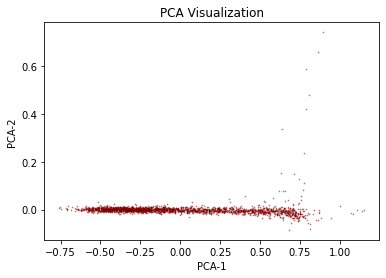

In [194]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)

plt.clf()
fig = plt.figure(figsize=(6,4))

plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()

In [197]:
train_copy = pd.concat([train_copy, emb_df.T], axis=1)
train_copy

,id,keyword,location,text,target,num chars,num special chars,country,country freq,keyword_0,...,leisure,fashionable,tutorial,entering,sand,regarding,belt,chill,racist,hike
0,1,NaN,nan,"[earthquake, us]",1,69,1,NAN,0.959149,0,...,-0.040497,-0.029635,-0.026505,-0.037659,-0.035906,-0.025804,-0.047058,-0.028801,-0.038910,-0.026311
1,4,NaN,nan,"[fire, near]",1,38,1,NAN,0.959149,0,...,0.048072,0.019684,0.028122,0.030772,0.044950,0.027938,0.057919,0.033254,0.039047,0.043394
2,5,NaN,nan,"[shelter, place, notified, evacuation, shelter...",1,133,3,NAN,0.959149,0,...,-0.003123,0.002632,0.000734,0.007961,-0.004750,0.002605,-0.004459,0.000416,-0.001208,-0.002411
3,6,NaN,nan,"[people, receive, evacuation]",1,65,2,NAN,0.959149,0,...,-0.005060,-0.011948,0.001408,-0.008373,-0.003066,0.002400,-0.004543,-0.006767,-0.003742,-0.006501
4,7,NaN,nan,"[got, sent, photo, smoke, school]",1,88,2,NAN,0.959149,0,...,0.013722,0.009327,0.004536,-0.003345,0.012458,0.011774,0.006203,0.003652,0.001708,0.003489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,nan,"[giant, holding, bridge, collapse, nearby]",1,83,5,NAN,0.959149,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7609,10870,NaN,nan,"[aria, control, wild, even, part, state, troub...",1,125,5,NAN,0.959149,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7610,10871,NaN,nan,[],1,65,11,NAN,0.959149,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7611,10872,NaN,nan,"[investigating, bike, car, bike, rider, seriou...",1,137,5,NAN,0.959149,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
xtrain_copy = train_copy.drop(columns=['id', 'keyword', 'location', 'text', 'country', 'target'])

In [200]:
ytrain_copy = train_copy['target']

In [ ]:
xtest_copy = train_copy.drop(columns=['id', 'keyword', 'location', 'text', 'country'])

#xtest = pd.concat([test_copy, emb_df.T], axis=1) -> não tenho embedding do próprio test set